## Open3Dとは

PCL(Point Cloud Library)に不満を覚えて作成したライブラリらしい。

- Python API充実
- ドキュメント充実
- ビューワが使いやすい

が特徴。点群処理アルゴリズム自体はPCLのほうがまだ充実しているようなので併用か。

In [1]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from open3d import *

## 基本
ポイントクラウドの操作とか。まずポイントクラウドを読み込む。

In [3]:
pcd = read_point_cloud("../Open3d/build361/lib/TestData/fragment.pcd")

RGBとDepth画像をセットにして読み込む。

In [4]:
color_raw = read_image("../Open3d/build361/lib/TestData/RGBD/color/00000.jpg")
depth_raw = read_image("../Open3d/build361/lib/TestData/RGBD/depth/00000.png")
rgbd_image = create_rgbd_image_from_color_and_depth( color_raw, depth_raw);

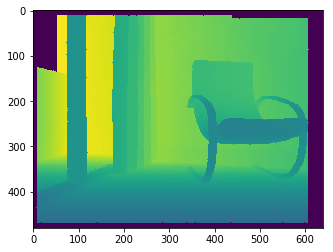

In [5]:
plt.imshow(rgbd_image.depth)

カメラパラメータがあれば Point Cloudに変換できる。

In [6]:
pcd = create_point_cloud_from_rgbd_image(rgbd_image, PinholeCameraIntrinsic(
        PinholeCameraIntrinsicParameters.PrimeSenseDefault))
#draw_geometries([pcd],width=640,height=480)  # ビューワの解像度指定

PointCloudがほしいだけなら、RGBは不要で、depthとカメラパラメータだけでいい。

In [7]:
pcd2=create_point_cloud_from_depth_image(depth_raw, PinholeCameraIntrinsic(PinholeCameraIntrinsicParameters.PrimeSenseDefault))

PinholeCameraIntrinsicクラスは、幅・高さ・変換行列のようなので、openCVのキャリブ結果から簡単に引き出せるかな。

In [8]:
pc=PinholeCameraIntrinsic(PinholeCameraIntrinsicParameters.PrimeSenseDefault)
print(pc.width, "\n" , pc.height, "\n", pc.intrinsic_matrix)

640 
 480 
 [[525.    0.  319.5]
 [  0.  525.  239.5]
 [  0.    0.    1. ]]


点群をNDArray()として取り出すのは下記のようにする。

In [9]:
p=np.asarray(pcd2.points)

逆に、点群データからPointCloudクラスを作るには下記。

In [10]:
xyz=[[-1,-1,1],[1,1,1],[1,-1,1],[-1,1,1]]
pcd3= PointCloud()
pcd3.points = Vector3dVector(xyz)

## オフラインレンダリング

ビューワ(draw_geometries)にはいろんなキーバインドがある。[h]キーを押すとコンソールにヘルプが表示される。
[o]キーを押すとjson形式でレンダリング設定をセーブするらしい。

画像のワンショットを取るのは下記でいけそう。レンダリング設定のjsonを読みたい場合はコメントアウトしているところを直せばよし。
[OSMesaを使う方法もある](http://www.open3d.org/docs/tutorial/Advanced/headless_rendering.html)がビルドめんどくさいしいいや。

In [11]:
def capture_img(pcd):
    vis = Visualizer()
    vis.create_window(width=640,height=480)
    #vis.get_render_option().load_from_json(RENDER_JSON_FILE)
    vis.add_geometry(pcd)
    img=vis.capture_screen_float_buffer(True)
    vis.destroy_window()
    return img

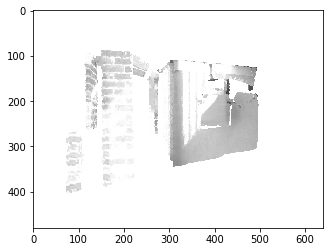

In [12]:
img=capture_img(pcd)
plt.imshow(img)

ダウンサンプリングして表示

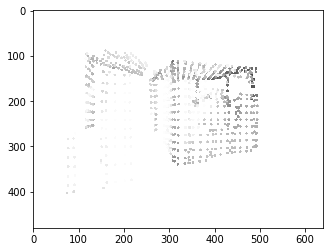

In [13]:
plt.imshow( capture_img( voxel_down_sample(pcd, voxel_size = 0.1)))

## RGBOdmetry
２枚のRGBD画像の間の変換行列を求める。SLAMとかで使う。

## KDTree
データ間の距離を基準にツリー状に並べたデータ構造で表現する。
近傍点の探索等を高速化するため。

## Registration
位置合わせ。初期値を必要とするものをlocal registration、必要としないものをglobal registrationと呼ぶ。globalは計算量の関係から荒いポイントクラウドで行い、globalで求まった解を初期値にしてlocal registrationを行う。

- local
    - ICP
    -  Colored point cloud registration
- global
    - RANSAC　遅いらしい
    - Zhou2016 早いらしい

ということで、Zhou2016 -> ICPをやってみよう。



複数視点のPointCloudを一つにまとめるmultiway registrationというやつもある。

## Segmentation

セグメンテーションは未実装みたい。python-pclはいちおう対応しているようだ。